In [2]:
include("../LiPoSID.jl")
using QuantumOptics
basis = NLevelBasis(2)
using LinearAlgebra
using Plots
using StatsPlots
using Dates
using HDF5

In [3]:
function DMD_SVD(Y, r, Δt)
    
    X₋ = Y[:,1:end-1]
    X₊ = Y[:,2:end]
    U, Σ, V = svd(X₋)
    
    Uʳ = U[:, 1:r] #12 x 4
    Σʳ = diagm(Σ[1:r])
    Vʳ = V[:, 1:r]
    Ã = Uʳ' * X₊ * Vʳ / Σʳ
    Λ, W = eigen(Ã)
    Φ = X₊ * Vʳ / Σʳ * W
    Ω = log.(Λ)/Δt
    x₁ = X₋[:,1]
    b₁ = Φ \ x₁
    
    return Φ, Ω, b₁, Λ

end    

function DMD_reconstruct(Φ, Ω, b₁, Δt, steps)

    Yᵈᵐᵈ = hcat([real.(Φ * (b₁ .* exp.(Ω * (i * Δt)))) for i in 0:steps]...)
    
    return Yᵈᵐᵈ

end


function DMDvsERA_lme_basis(γᵢ, n)
    data_dir = "../DATA/"

    γᵢ = string(γᵢ)

    if parse(Float64, γᵢ) < 0.079 # γᵢ == "0.0" 
            ρᵉ, tᵉ = LiPoSID.get_rho_series(data_dir*"State_B2_2CUT_data.h5", "0.079477")
            ρᵍ, tᵍ = LiPoSID.get_rho_series(data_dir*"State_B1_2CUT_data.h5", "0.079477")
            ρˣ, tˣ = LiPoSID.get_rho_series(data_dir*"State_B3_2CUT_data.h5", "0.079477")
            ρʸ, tʸ = LiPoSID.get_rho_series(data_dir*"State_B4_2CUT_data.h5", "0.079477")
    else 
            ρᵉ, tᵉ = LiPoSID.get_rho_series(data_dir*"State_B2_2CUT_data.h5", γᵢ)
            ρᵍ, tᵍ = LiPoSID.get_rho_series(data_dir*"State_B1_2CUT_data.h5", γᵢ)
            ρˣ, tˣ = LiPoSID.get_rho_series(data_dir*"State_B3_2CUT_data.h5", γᵢ)
            ρʸ, tʸ = LiPoSID.get_rho_series(data_dir*"State_B4_2CUT_data.h5", γᵢ)
    end

    
    lᵉ = length(ρᵉ); lᵍ = length(ρᵍ); lˣ = length(ρˣ); lʸ = length(ρʸ)
    lᵐᵃˣ = min(lᵉ, lᵍ,  lˣ, lʸ)  #choose time limit by shortest series

    tᵉᶠ = convert.(Float64, tᵉ); tᵍᶠ = convert.(Float64, tᵍ); 
    tˣᶠ = convert.(Float64, tˣ); tʸᶠ = convert.(Float64, tʸ); 

    Hᴸᴹᴱ = [ 25.126        0
             0             0    ]
    
    γᶠ = parse(Float64, γᵢ)

    Aᴸᴹᴱ = [ 0    √(γᶠ)
             0     0. + 0im  ]

    tᵉᶠ = convert.(Float64, tᵉ); tᵍᶠ = convert.(Float64, tᵍ); 
    tˣᶠ = convert.(Float64, tˣ); tʸᶠ = convert.(Float64, tʸ); 

    ρᵉᴸᴹᴱ = LiPoSID.Lindblad_time_evolution(basis, ρᵉ[1], tᵉᶠ, Hᴸᴹᴱ, [Aᴸᴹᴱ])
    ρᵍᴸᴹᴱ = LiPoSID.Lindblad_time_evolution(basis, ρᵍ[1], tᵍᶠ, Hᴸᴹᴱ, [Aᴸᴹᴱ])
    ρˣᴸᴹᴱ = LiPoSID.Lindblad_time_evolution(basis, ρˣ[1], tˣᶠ, Hᴸᴹᴱ, [Aᴸᴹᴱ])
    ρʸᴸᴹᴱ = LiPoSID.Lindblad_time_evolution(basis, ρʸ[1], tʸᶠ, Hᴸᴹᴱ, [Aᴸᴹᴱ])

    bᵉᴸᴹᴱ = LiPoSID.bloch(ρᵉᴸᴹᴱ[1:lᵐᵃˣ])
    bᵍᴸᴹᴱ = LiPoSID.bloch(ρᵍᴸᴹᴱ[1:lᵐᵃˣ])
    bˣᴸᴹᴱ = LiPoSID.bloch(ρˣᴸᴹᴱ[1:lᵐᵃˣ])
    bʸᴸᴹᴱ = LiPoSID.bloch(ρʸᴸᴹᴱ[1:lᵐᵃˣ])

    Y = [bᵉᴸᴹᴱ; bᵍᴸᴹᴱ; bˣᴸᴹᴱ; bʸᴸᴹᴱ]

    t = convert.(Float64, tᵉᶠ[1:lᵐᵃˣ])
    Δt = t[2]-t[1]

    # DMD (Dynamic mode decomposition)
    
    Φ, Ω, b₁, Λᴰᴹᴰ = DMD_SVD(Y, n, Δt)
    Yᴰᴹᴰ = DMD_reconstruct(Φ, Ω, b₁, Δt, length(t))

    bᵉᴰᴹᴰ = Yᴰᴹᴰ[1:3,:]
    bᵍᴰᴹᴰ = Yᴰᴹᴰ[4:6,:]
    bˣᴰᴹᴰ = Yᴰᴹᴰ[7:9,:]
    bʸᴰᴹᴰ = Yᴰᴹᴰ[10:12,:]

    ρᵉᴰᴹᴰ = LiPoSID.rho_series_from_bloch(bᵉᴰᴹᴰ)
    ρᵍᴰᴹᴰ = LiPoSID.rho_series_from_bloch(bᵍᴰᴹᴰ)
    ρˣᴰᴹᴰ = LiPoSID.rho_series_from_bloch(bˣᴰᴹᴰ)
    ρʸᴰᴹᴰ = LiPoSID.rho_series_from_bloch(bʸᴰᴹᴰ)

    ρᴰᴹᴰ = [ρᵉᴰᴹᴰ, ρᵍᴰᴹᴰ, ρˣᴰᴹᴰ, ρʸᴰᴹᴰ]

    # ERA (Eigenvalue Realization Algorithm)

    Aᴱᴿᴬ, Cᴱᴿᴬ, x₀ᴱᴿᴬ, Σᴱᴿᴬ = LiPoSID.lsid_n_ACx0Σ(Y, Δt, n) 

    Yᴱᴿᴬ = LiPoSID.propagate_LTI(Aᴱᴿᴬ, Cᴱᴿᴬ, x₀ᴱᴿᴬ, n, length(t))

    Λᴱᴿᴬ, Wᴱᴿᴬ = eigen(Aᴱᴿᴬ)

    bᵉᴱᴿᴬ = Yᴱᴿᴬ[1:3,:]
    bᵍᴱᴿᴬ = Yᴱᴿᴬ[4:6,:]
    bˣᴱᴿᴬ = Yᴱᴿᴬ[7:9,:]
    bʸᴱᴿᴬ = Yᴱᴿᴬ[10:12,:]

    ρᵉᴱᴿᴬ = LiPoSID.rho_series_from_bloch(bᵉᴱᴿᴬ)
    ρᵍᴱᴿᴬ = LiPoSID.rho_series_from_bloch(bᵍᴱᴿᴬ)
    ρˣᴱᴿᴬ = LiPoSID.rho_series_from_bloch(bˣᴱᴿᴬ)
    ρʸᴱᴿᴬ = LiPoSID.rho_series_from_bloch(bʸᴱᴿᴬ)

    ρᴱᴿᴬ = [ρᵉᴱᴿᴬ, ρᵍᴱᴿᴬ, ρˣᴱᴿᴬ, ρʸᴱᴿᴬ]
    
    return ρᴱᴿᴬ, ρᴰᴹᴰ, Λᴱᴿᴬ, Λᴰᴹᴰ, t[1:lᵐᵃˣ]
    
end

function propagate_rho_O1XY(ρ₀, ρᵉᵍˣʸ, steps)

    hcat(vec[ρᵢ] for ρᵢ in ρᵉᵍˣʸ)

    kᵉᵍˣʸ = hcat([vec(ρᵢ[1]) for ρᵢ in ρᵉᵍˣʸ]...)\vec(ρ₀)

    kᵉ, kᵍ, kˣ, kʸ = kᵉᵍˣʸ              
    ρᵉ, ρᵍ, ρˣ, ρʸ = ρᵉᵍˣʸ

    ρ = kᵉ * ρᵉ + kᵍ * ρᵍ + kˣ * ρˣ + kʸ * ρʸ

    return ρ
end 

propagate_rho_O1XY (generic function with 1 method)

In [4]:
function xyz(b)
    x = b[1, :]
    y = b[2, :]
    z = b[3, :]
    return x,y,z
end

using Plots; plotlyjs()

function sphere(r, C)   # r: radius; C: center [cx,cy,cz]
    n = 100
    u = range(-π, π; length = n)
    v = range(0, π; length = n)
    x = C[1] .+ r*cos.(u) * sin.(v)'
    y = C[2] .+ r*sin.(u) * sin.(v)'
    z = C[3] .+ r*ones(n) * cos.(v)'
    return x, y, z
end

sphere (generic function with 1 method)

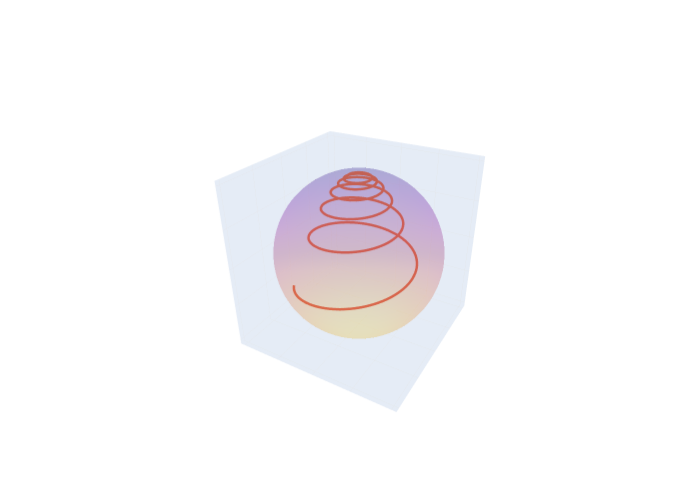

In [8]:
data_dir = "../DATA/"
df_tst = "State_D11"

γ = ["0.0", "0.079477",  "0.25133", "0.79477", "2.5133", "7.9477", "25.133",  "79.477", "251.33"]

γᵢ = "2.5133"
n = 4

Hᴸᴹᴱ = [ 25.126        0
          0            0    ]

γᶠ = parse(Float64, γᵢ)

Aᴸᴹᴱ = [ 0    √(γᶠ)
         0     0. + 0im  ]

if parse(Float64, γᵢ) < 0.079 # γᵢ == "0.0" 
    ρᵗˢᵗ, tᵗˢᵗ = LiPoSID.get_rho_series(data_dir*df_tst*"_2CUT_data.h5", "0.079477")

else 
    ρᵗˢᵗ, tᵗˢᵗ = LiPoSID.get_rho_series(data_dir*df_tst*"_2CUT_data.h5", γᵢ)
end

if length(tᵗˢᵗ) > 1200 end_tst = 1200 else end_tst = length(tᵗˢᵗ) end

ρᴱᴿᴬ, ρᴰᴹᴰ, Λᴱᴿᴬ, Λᴰᴹᴰ, t = DMDvsERA_lme_basis(γᵢ, n)
ρᵉᴰᴹᴰ, ρᵍᴰᴹᴰ, ρˣᴰᴹᴰ, ρʸᴰᴹᴰ = ρᴰᴹᴰ
ρᵉᴱᴿᴬ, ρᵍᴱᴿᴬ, ρˣᴱᴿᴬ, ρʸᴱᴿᴬ = ρᴱᴿᴬ
ρᵗˢᵗᴱᴿᴬ =  propagate_rho_O1XY(ρᵗˢᵗ[1], ρᴱᴿᴬ, 20)
ρᵗˢᵗᴰᴹᴰ =  propagate_rho_O1XY(ρᵗˢᵗ[1], ρᴰᴹᴰ, 20)

tᵗˢᵗᶠ = convert.(Float64, tᵗˢᵗ)

ρᵗˢᵗᴸᴹᴱ = LiPoSID.Lindblad_time_evolution(basis, ρᵗˢᵗ[1], tᵗˢᵗᶠ, Hᴸᴹᴱ, [Aᴸᴹᴱ])
ρᵗˢᵗᴸᴹᴱ = convert(Vector{Matrix{ComplexF64}}, ρᵗˢᵗᴸᴹᴱ[1:end_tst])

bᵗˢᵗᴸᴹᴱ = LiPoSID.bloch(ρᵗˢᵗᴸᴹᴱ)
bᵗˢᵗᴰᴹᴰ = LiPoSID.bloch(ρᵗˢᵗᴰᴹᴰ)

plt = surface(sphere(1, [0,0,0]), alpha=0.4, c=cgrad(:plasma, rev=true), showaxis = false, colorbar=false, size = (1200, 1200))
plt = Plots.plot!(xyz(bᵗˢᵗᴸᴹᴱ), label = "", linewidth=5) #, label = "EXACT")
#plt = Plots.plot!(xyz(bᵗˢᵗᴰᴹᴰ), label="DMD", linewidth=5)
#savefig(plt, "Trajectory_in_Bloch.pdf")

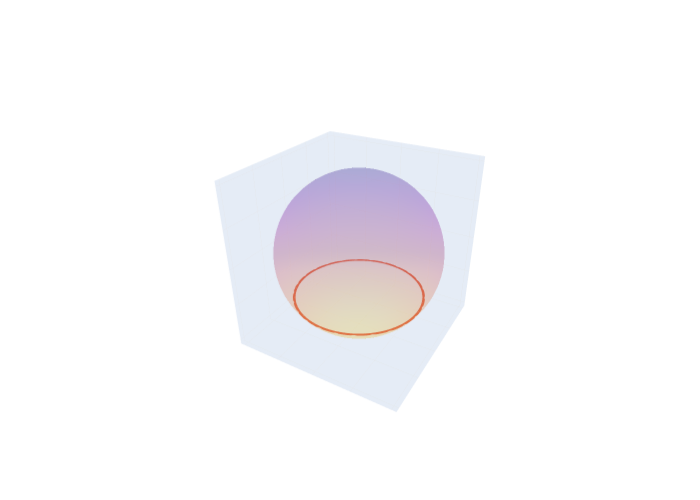

In [10]:
data_dir = "../DATA/"
df_tst = "State_D11"

γ = ["0.0", "0.079477",  "0.25133", "0.79477", "2.5133", "7.9477", "25.133",  "79.477", "251.33"]

γᵢ = "0.0"

Hᴸᴹᴱ = [ 25.126        0
          0            0    ]

γᶠ = parse(Float64, γᵢ)

Aᴸᴹᴱ = [ 0    √(γᶠ)
         0     0. + 0im  ]

if parse(Float64, γᵢ) < 0.079 # γᵢ == "0.0" 
    ρᵗˢᵗ, tᵗˢᵗ = LiPoSID.get_rho_series(data_dir*df_tst*"_2CUT_data.h5", "0.079477")

else 
    ρᵗˢᵗ, tᵗˢᵗ = LiPoSID.get_rho_series(data_dir*df_tst*"_2CUT_data.h5", γᵢ)
end

if length(tᵗˢᵗ) > 1200 end_tst = 1200 else end_tst = length(tᵗˢᵗ) end

tᵗˢᵗᶠ = convert.(Float64, tᵗˢᵗ)

#end_tst = 500

ρᵗˢᵗᴸᴹᴱ = LiPoSID.Lindblad_time_evolution(basis, ρᵗˢᵗ[1], tᵗˢᵗᶠ, Hᴸᴹᴱ, [Aᴸᴹᴱ])
ρᵗˢᵗᴸᴹᴱ = convert(Vector{Matrix{ComplexF64}}, ρᵗˢᵗᴸᴹᴱ[1:end_tst])

bᵗˢᵗᴸᴹᴱ = LiPoSID.bloch(ρᵗˢᵗᴸᴹᴱ)

plt = surface(sphere(1, [0,0,0]), alpha=0.4, c=cgrad(:plasma, rev=true), showaxis = false, colorbar=false, size = (1200, 1200))
plt = Plots.plot!(xyz(bᵗˢᵗᴸᴹᴱ), label="", linewidth=1) #, label = "Exact LME")
#savefig(plt, "Trajectory_in_Bloch.pdf")

In [29]:
plt = surface(sphere(1, [0,0,0]), alpha=0.4, c=cgrad(:plasma, rev=true), showaxis = false, colorbar=false, size = (1200, 1200))
plt = Plots.plot!(xyz(bᵗˢᵗᴸᴹᴱ), label="", size = (1200, 1200)) #, label = "Exact LME")
savefig(plt, "LME_trajectory_in_Bloch.pdf")

"/home/zah/github/OQSID-thesis/DMDvsERA/LME_trajectory_in_Bloch.pdf"

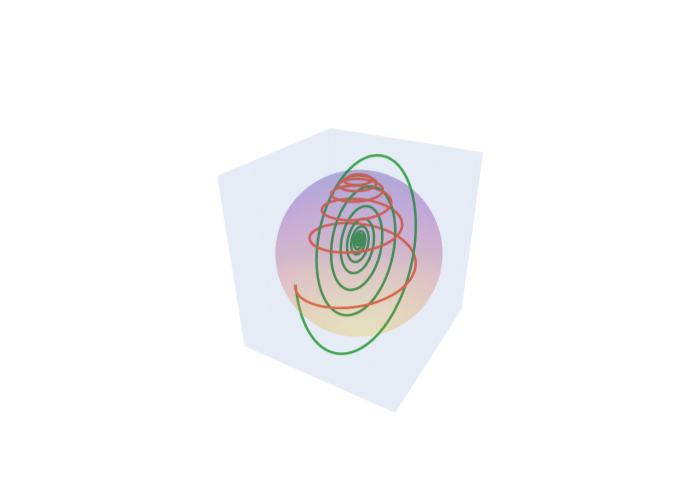

In [7]:
data_dir = "../DATA/"
df_tst = "State_D11"

γ = ["0.0", "0.079477",  "0.25133", "0.79477", "2.5133", "7.9477", "25.133",  "79.477", "251.33"]

γᵢ = "2.5133"
n = 3

Hᴸᴹᴱ = [ 25.126        0
          0            0    ]

γᶠ = parse(Float64, γᵢ)

Aᴸᴹᴱ = [ 0    √(γᶠ)
         0     0. + 0im  ]

if parse(Float64, γᵢ) < 0.079 # γᵢ == "0.0" 
    ρᵗˢᵗ, tᵗˢᵗ = LiPoSID.get_rho_series(data_dir*df_tst*"_2CUT_data.h5", "0.079477")

else 
    ρᵗˢᵗ, tᵗˢᵗ = LiPoSID.get_rho_series(data_dir*df_tst*"_2CUT_data.h5", γᵢ)
end

if length(tᵗˢᵗ) > 1200 end_tst = 1200 else end_tst = length(tᵗˢᵗ) end

ρᴱᴿᴬ, ρᴰᴹᴰ, Λᴱᴿᴬ, Λᴰᴹᴰ, t = DMDvsERA_lme_basis(γᵢ, n)
ρᵉᴰᴹᴰ, ρᵍᴰᴹᴰ, ρˣᴰᴹᴰ, ρʸᴰᴹᴰ = ρᴰᴹᴰ
ρᵉᴱᴿᴬ, ρᵍᴱᴿᴬ, ρˣᴱᴿᴬ, ρʸᴱᴿᴬ = ρᴱᴿᴬ
ρᵗˢᵗᴱᴿᴬ =  propagate_rho_O1XY(ρᵗˢᵗ[1], ρᴱᴿᴬ, 20)
ρᵗˢᵗᴰᴹᴰ =  propagate_rho_O1XY(ρᵗˢᵗ[1], ρᴰᴹᴰ, 20)

tᵗˢᵗᶠ = convert.(Float64, tᵗˢᵗ)

ρᵗˢᵗᴸᴹᴱ = LiPoSID.Lindblad_time_evolution(basis, ρᵗˢᵗ[1], tᵗˢᵗᶠ, Hᴸᴹᴱ, [Aᴸᴹᴱ])
ρᵗˢᵗᴸᴹᴱ = convert(Vector{Matrix{ComplexF64}}, ρᵗˢᵗᴸᴹᴱ[1:end_tst])

bᵗˢᵗᴸᴹᴱ = LiPoSID.bloch(ρᵗˢᵗᴸᴹᴱ)
bᵗˢᵗᴰᴹᴰ = LiPoSID.bloch(ρᵗˢᵗᴰᴹᴰ)
bᵗˢᵗᴱᴿᴬ = LiPoSID.bloch(ρᵗˢᵗᴱᴿᴬ)

plt = surface(sphere(1, [0,0,0]), alpha=0.4, c=cgrad(:plasma, rev=true), showaxis = false, colorbar=false, size = (1200, 1200))
plt = Plots.plot!(xyz(bᵗˢᵗᴸᴹᴱ), label = "", linewidth=5) #, label = "EXACT")
plt = Plots.plot!(xyz(bᵗˢᵗᴰᴹᴰ), label="", linewidth=5)#, label="DMD",
#plt = Plots.plot!(xyz(bᵗˢᵗᴱᴿᴬ), label="", linewidth=5) 
#savefig(plt, "Trajectory_in_Bloch.pdf")